# Los Angeles Greater Area Sales Price Prediction

### *A Project on behalf of Housetable Ltd*

![](/home/shua/Desktop/msc-ml-datamining/Machine_Learning/project/v3/losangeles.jpg)

## Introduction

Housetable is a young startup in Israel, working in the Fintech sector of the young startup scene. Housetable lets American homeowners know what their home will be worth after renovations, its expected costs and timeline, as well as a curated list of improvements that are most likely to increase its value, powered by AI.

An important aspect to this process is the current value of the home, pre-renovation. To do this, they gathered a small dataset of houses and their sale data. Every house has at least 2 entries for different sales at different times. Each sales information was gathered along with the images the homeowner took of the property at listing time. The images were run by Housetables in-house computer vision aglorithms to understand the quality and condition of the interior of the home, and these features were appended to the metadata for its corresponding row.

**The task is to try and create an algorithm to understand the current valuation of homes in the Los Angeles area**, a large and diverse enough area to assume that if the model can learn well enough in Los Angeles, its performance could be consistent in other areas as well.

#### Table of Contents:
1. EDA and Cleaning
    * Feature Selection
    * Understanding and Cleaning the Target Value
    * Simple Imputations and Feature Cleaning
    * Skew and Coorelations
2. Feature Engineering
    * Fill values by aggregation
    * Create Age and Overall Quality Features
    * One Hot and Ordinal Encoding
    * Outlier Removal
3. Final Data Prep
    * Drop Unuseable Columns
    * Min Max Scaling
    * KNN Imputer
4. Modeling
    * Without Previous Sales
    * With Previous Sales (XGBoost)
5. Making Use of the Historical Data
    * Add Conditions of the Previous Sale to Current Sale
    * Retry the Models

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
#Turn off settingwithcopy warning
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.6f}'.format

In [2]:
main_df = pd.read_csv(r'/home/shua/Desktop/msc-ml-datamining/Machine_Learning/project/v3/data/difference_df.csv').drop(['Unnamed: 0'], axis = 1)

/tmp/ipykernel_224872/293814267.py:1: DtypeWarning: Columns (3,4,12,15,146,245,246,250,260,276,288,289,290,291,294,295,296,297,298,300,301,302,303,304,305,309,311,312,313,314,319,320,321,322,323,324,325,326,327,331,332,333,335,336,337,339,342,344,345,351,352,354,356,357,358,360,361,363,364) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv(r'/home/shua/Desktop/msc-ml-datamining/Machine_Learning/project/v3/data/difference_df.csv').drop(['Unnamed: 0'], axis = 1)


In [3]:
#show sale_price 10 max, show columns sale_price, prev_sale_price and sale.lastSale.price
main_df[['sale_price', 'prev_sale_price', 'sale.lastSale.price']].sort_values(by = 'sale_price', ascending = False).head(10)

,sale_price,prev_sale_price,sale.lastSale.price
34,102049000.000000,775000.000000,1020500.000000
3408,9800000.000000,9000000.000000,9800000.000000
3409,9000000.000000,NaN,9800000.000000
725,4000000.000000,3810000.000000,4000000.000000
740,3950000.000000,3650000.000000,3950000.000000
3398,3900000.000000,3725000.000000,3900000.000000
726,3810000.000000,NaN,4000000.000000
738,3800000.000000,3210000.000000,3800000.000000
3399,3725000.000000,NaN,3900000.000000
741,3650000.000000,NaN,3950000.000000


## 1)Exploratory Data Analysis

In [4]:
main_df.head()

,full_address,street,sale_year,prev_sale_year,sale_price,prev_sale_price,price_difference,address,street_b,city,...,Floor_min_tagged,Floor_std_tagged,Floor_mean_tagged,Walls_max_tagged,Walls_min_tagged,Walls_std_tagged,Walls_mean_tagged,Outview_tagged,Outview_std_tagged,s_tagged
0,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913 york blvd,2021,2019.000000,1030000.000000,725000.000000,305000.000000,"3913 york boulevard, los angeles, ca 90065 sol...",3913 york blvd,los angeles,...,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,5.000000,2.000000,1.000000,NaN
1,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913 york blvd,2019,NaN,725000.000000,NaN,NaN,"3913 york boulevard, los angeles, ca 90065 sol...",3913 york blvd,los angeles,...,2.000000,1.000000,3.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000,NaN
2,"4171 Division Street, Los Angeles, CA 90065 So...",4171 division st,2020,2015.000000,905000.000000,680000.000000,225000.000000,"4171 division street, los angeles, ca 90065 so...",4171 division st,los angeles,...,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000,NaN
3,"4171 Division Street, Los Angeles, CA 90065 So...",4171 division st,2015,NaN,680000.000000,NaN,NaN,"4171 division street, los angeles, ca 90065 so...",4171 division st,los angeles,...,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,3.000000,2.000000,0.000000,NaN
4,"4234 Palmero Drive, Los Angeles, CA 90065 Sold...",4234 palmero dr,2020,2017.000000,1260000.000000,844000.000000,416000.000000,"4234 palmero drive, los angeles, ca 90065 sold...",4234 palmero dr,los angeles,...,2.000000,1.000000,3.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000,NaN


In [5]:
main_df.shape

(4339, 391)

The feature set is rather large-- 391 columns. Let's take a look and see how many of these are actually useable

### a)Basic Feature Selection

In [6]:
#filter the dataframe to only include columns with at least 50% fill rates
main_df.loc[:, main_df.isnull().mean() < .5].shape

(4339, 245)

With a threshold of 50% fill rates, we managed to remove about 35% of the columns. Lets see what columns we have left:

In [7]:
filtered_df = main_df.loc[:, main_df.isnull().mean() < .5]
filtered_df.iloc[:, :90].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 90 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   full_address                               4339 non-null   object 
 1   street                                     4339 non-null   object 
 2   sale_year                                  4339 non-null   object 
 3   prev_sale_year                             2212 non-null   object 
 4   sale_price                                 4339 non-null   float64
 5   prev_sale_price                            2212 non-null   float64
 6   price_difference                           2212 non-null   float64
 7   address                                    4339 non-null   object 
 8   street_b                                   4339 non-null   object 
 9   city                                       4339 non-null   object 
 10  state                   

In [8]:
filtered_df.iloc[:, 90:180].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ids.quantariumUrn                         4327 non-null   float64
 1   ids.fipsCode                              4339 non-null   int64  
 2   ids.personIds                             4339 non-null   object 
 3   involuntaryLien.liens                     4339 non-null   object 
 4   legal.legalDescription                    4339 non-null   object 
 5   legal.lotNumber                           4054 non-null   object 
 6   legal.cityTownshipMunicipality            4339 non-null   object 
 7   legal.tractNumber                         4319 non-null   object 
 8   lot.lotSizeAcres                          4333 non-null   float64
 9   lot.lotDepthFeet                          2886 non-null   float64
 10  lot.lotFrontageFeet                 

In [9]:
filtered_df.iloc[:, 180:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 65 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sale.lastSale.price                      4304 non-null   float64
 1   sale.lastSale.priceCodeDescription       3954 non-null   object 
 2   sale.lastSale.priceCode                  4192 non-null   float64
 3   sale.lastSale.recordingDate              4330 non-null   object 
 4   sale.lastSale.saleDate                   4330 non-null   object 
 5   sale.lastSale.saleBuyers                 4339 non-null   object 
 6   sale.lastSale.saleSellers                4339 non-null   object 
 7   sale.lastSale.mortgages                  4330 non-null   object 
 8   sale.priorTransfer.saleBuyers            4339 non-null   object 
 9   sale.priorTransfer.saleSellers           4339 non-null   object 
 10  sale.priorSale.documentNumber            4306 no

#### Domain knowledge tells us that many of these features are un-useable/not helpful. This would include the general (with the exception of propertyType.detail), valuation (data leak), quicklists, address, owner, and demographic categories. So we can remove these:

In [10]:
# remove columns if column starts with any of general, valuation, quicklists, address, owner, and demographic, ids, and categories
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('general')]
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('valuation')]
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('quicklists')]
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('address')]
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('owner')]
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('demographic')]
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('ids')]
filtered_df = filtered_df.loc[:, ~filtered_df.columns.str.lower().str.startswith('categories')]
filtered_df.shape


(4339, 147)

In [11]:
#Search through the filtered_df and print a dataframe of just the object columns
object_df = filtered_df.select_dtypes(include=['object'])
object_df.head()

,full_address,street,sale_year,prev_sale_year,street_b,city,state,zip,sold_month,sold_day,...,sale.priorSale.recordingDate,sale.priorSale.saleDate,sale.priorSale.saleBuyers,sale.priorSale.saleSellers,sale.priorSale.mortgages,tax.taxRateCodeArea,meta.importEvents,meta.requestId,date_sold_tagged,sub_type_tagged
0,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913 york blvd,2021,2019.000000,3913 york blvd,los angeles,ca,90065,may,17,...,2019-05-15T00:00:00.000Z,2019-05-09T00:00:00.000Z,['Spencer Scott William'],['West Adams Group Llc'],"[{'documentNumber': '2019.443302', 'pageNumber...",00-013,[],r2H7QRoLHH,2021-05-17 00:00:00,S
1,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913 york blvd,2019,NaN,3913 york blvd,los angeles,ca,90065,may,15,...,2019-05-15T00:00:00.000Z,2019-05-09T00:00:00.000Z,['Spencer Scott William'],['West Adams Group Llc'],"[{'documentNumber': '2019.443302', 'pageNumber...",00-013,[],r2H7QRoLHH,2019-05-15 00:00:00,S
2,"4171 Division Street, Los Angeles, CA 90065 So...",4171 division st,2020,2015.000000,4171 division st,los angeles,ca,90065,december,4,...,2015-07-22T00:00:00.000Z,2015-06-19T00:00:00.000Z,"['Vergara Ryan Trajan', 'Vergara Tracy Liu']",['Berman Shane Michael'],"[{'documentNumber': '2015.887850', 'pageNumber...",00-004,[],GR0zGKANLk,2020-12-04 00:00:00,S
3,"4171 Division Street, Los Angeles, CA 90065 So...",4171 division st,2015,NaN,4171 division st,los angeles,ca,90065,july,22,...,2015-07-22T00:00:00.000Z,2015-06-19T00:00:00.000Z,"['Vergara Ryan Trajan', 'Vergara Tracy Liu']",['Berman Shane Michael'],"[{'documentNumber': '2015.887850', 'pageNumber...",00-004,[],GR0zGKANLk,2015-07-22 00:00:00,S
4,"4234 Palmero Drive, Los Angeles, CA 90065 Sold...",4234 palmero dr,2020,2017.000000,4234 palmero dr,los angeles,ca,90065,september,24,...,2017-03-17T00:00:00.000Z,2017-02-09T00:00:00.000Z,"['Hoffman Matthew Justin', 'Shelley Noelle Mar...","['Kim Sang Jean', 'Choi David T']","[{'documentNumber': '2017.304648', 'pageNumber...",00-004,[],IjNuIQ38sN,2020-09-24 00:00:00,S


As we can see, not all of the features in our dataset are numerical, and will require a decent amount of pre-processing (and thereby feature selection, as not all seem to be able to go through any helpful transoformations).

Two features we can see are actually holding dictionaries: building.features, and homeownerAssociations. Both of these we can sparse later, and get valuable features from.

the general.propertyTypeDetail seems to be ordinal, and can apply an Ordinal Encoder to.

'building.styleCode', 'building.roofCover','building.exteriorWalls', 'building.heatSource', 'building.constructionType' are all columns which we can apply one hot encoding to.

In [12]:
# Search through the filtered dataframe and print a dataframe of the numeric columns
numeric_df = filtered_df.select_dtypes(include=['float64', 'int64'])
numeric_df.head(30)

,sale_price,prev_sale_price,price_difference,assessment.assessedImprovementValue,assessment.assessedLandValue,assessment.totalAssessedValue,assessment.assessmentYear,building.totalBuildingAreaSquareFeet,building.yearBuilt,building.effectiveYearBuilt,...,Floor_max_tagged,Floor_min_tagged,Floor_std_tagged,Floor_mean_tagged,Walls_max_tagged,Walls_min_tagged,Walls_std_tagged,Walls_mean_tagged,Outview_tagged,Outview_std_tagged
0,1030000.000000,725000.000000,305000.000000,149432,597728,747160,2021,1121.000000,1939.000000,2005.000000,...,5.000000,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,5.000000,2.000000,1.000000
1,725000.000000,NaN,NaN,149432,597728,747160,2021,1121.000000,1939.000000,2005.000000,...,5.000000,2.000000,1.000000,3.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000
2,905000.000000,680000.000000,225000.000000,181000,724000,905000,2021,1250.000000,1947.000000,1947.000000,...,5.000000,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000
3,680000.000000,NaN,NaN,181000,724000,905000,2021,1250.000000,1947.000000,1947.000000,...,5.000000,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,3.000000,2.000000,0.000000
4,1260000.000000,844000.000000,416000.000000,302600,957400,1260000,2021,1258.000000,1955.000000,1955.000000,...,5.000000,2.000000,1.000000,3.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000
5,844000.000000,NaN,NaN,302600,957400,1260000,2021,1258.000000,1955.000000,1955.000000,...,5.000000,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000
6,1317000.000000,865000.000000,452000.000000,267745,606216,873961,2021,1210.000000,1957.000000,1957.000000,...,5.000000,2.000000,1.000000,3.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000
7,865000.000000,NaN,NaN,267745,606216,873961,2021,1210.000000,1957.000000,1957.000000,...,5.000000,2.000000,1.000000,4.000000,5.000000,2.000000,1.000000,3.000000,2.000000,0.000000
8,1205000.000000,540000.000000,665000.000000,321660,589710,911370,2021,1206.000000,1925.000000,1935.000000,...,5.000000,2.000000,1.000000,3.000000,5.000000,2.000000,1.000000,4.000000,2.000000,1.000000
9,540000.000000,NaN,NaN,321660,589710,911370,2021,1206.000000,1925.000000,1935.000000,...,5.000000,2.000000,1.000000,3.000000,5.000000,2.000000,1.000000,3.000000,2.000000,0.000000


There are some really valuable features here. However, there are many redundant columns (for example, there are several data sources giving the same information, like the mls and building categories both having the building counts.) Other columns are irrelevant, as they represent id codes that can't be used, or document numbers.

For some of the redundant columns though, we can still use them in order to fill in each others missing values, and only keep one of them. We will do this later.

The assessment columns look extremely useful, but from an initial look, it seems like they represent some sort of data leakage. Furter research needs to be done on these columns before using them.

### *In summary, we will be using the following columns for prediction and pre-processing:*

In [13]:
address = ['full_address', 'address.houseNumber','street', 'city',
        'state', 'zip', 'address.zipPlus4', 'sold_month'
       ] #'address.latitude', 'address.longitude'

continuous = ['building.totalBuildingAreaSquareFeet',
       # 'building.unitCount',
       'building.bedroomCount', #'building.calculatedBathroomCount'
       'building.fullBathroomCount', 'building.bathroomCount',
       'lot.lotDepthFeet', 'lot.lotSizeSquareFeet','mls.lotSizeSquareFeet', 'mls.bedroomCount', 
       'building.storyCount', 'mls.floorCount', 'mls.bathroomCount',  'building.buildingQualityCode','sale.priorSale.price', 'prev_sale_price',#'assessment.totalAssessedValue'
       'assessment.assessedImprovementValue', 'assessment.assessedLandValue',
       'bedrooms_tagged',
       'living_area_tagged',
       'Bathroom_max_tagged',
       'Bathroom_min_tagged',
       'Bathroom_std_tagged',
       'Bathroom_mean_tagged',
       'Floor_max_tagged',
       'Floor_min_tagged',
       'Floor_std_tagged',
       'Floor_mean_tagged',
       'Walls_max_tagged',
       'Walls_min_tagged',
       'Walls_std_tagged',
       'Walls_mean_tagged',
       'Outview_tagged',
       'Outview_std_tagged',
       'Kitchen_level_tagged',
       'Kitchen_level_std_tagged']

    
#Notes: Need to reverse the ordinality of the buildingQualityCode

ordinal = ['general.propertyTypeDetail'] 

one_hot = ['building.styleCode', 'building.roofCover','building.exteriorWalls', 'building.heatSource', 'building.constructionType'] #'mls.heatingTypes', 'mls.coolingTypes'

to_sparse = ['building.features', 'homeownerAssociations']

# not_sure = [ 'building.heatSourceCode'] #OneHot? What to do with new values?

### b) Understanding the Target Variable

There are a couple of columns which relate to the Target variable:

In [14]:
#sale_price	prev_sale_price, sale.lastSale.price, sale.priorSale.price
targets = main_df.loc[:, ['sale.lastSale.price', 'sale.priorSale.price', 'sale_price', 'prev_sale_price']]
targets.head(10)

,sale.lastSale.price,sale.priorSale.price,sale_price,prev_sale_price
0,1030000.000000,725000.000000,1030000.000000,725000.000000
1,1030000.000000,725000.000000,725000.000000,NaN
2,905000.000000,680000.000000,905000.000000,680000.000000
3,905000.000000,680000.000000,680000.000000,NaN
4,1260000.000000,844000.000000,1260000.000000,844000.000000
5,1260000.000000,844000.000000,844000.000000,NaN
6,1317000.000000,865000.000000,1317000.000000,865000.000000
7,1317000.000000,865000.000000,865000.000000,NaN
8,1205000.000000,850000.000000,1205000.000000,540000.000000
9,1205000.000000,850000.000000,540000.000000,NaN


Our data set is comprised of two data sources regarding the target variable: The sale price and previous sale priced as collected by the data taggers, and the sale price and prev sale price as retrieved from the API call.

In [15]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sale.lastSale.price   4304 non-null   float64
 1   sale.priorSale.price  4292 non-null   float64
 2   sale_price            4339 non-null   float64
 3   prev_sale_price       2212 non-null   float64
dtypes: float64(4)
memory usage: 135.7 KB


We can see that the taggers sale price is more filled than the API cal. However, for production, the api call is the data source which will be using. Therefore, our main target column will be the API call's sale.lastSale.price, but we will use the tagger's data to fill in any missing values.

Another decision to be made, is which rows we will keep: The dataset consists of multiple sales for each house. As we can see, the oldest sale of the house doesn't have a prev_sale value. This is because the data is unknown to us (the api call only retrieves the most recent sale and prev_sale prices.) Most machine learning algorithms don't know how to calculate for null values, and therefore these rows will probably have to be dropped.

A solution could be is to aggregate the information of the prev_sale row into the current sale row (such as the tagged quality of the rooms, floors, and walls).

Another may be, that gradient boosting methods such as XGboost know how to account for NA values, and the rows could be salvaged there.

For now we will drop the prev_sale rows, and re-evaluate after our initial modeling. First,  we wil do some quick clean up o the target variable.

In [16]:
# main_df = main_df.dropna(subset = ['prev_sale_price']) #drop all rows without a target value

#### Clean the Target Variable

In [17]:
def fill_current_sale_for_previous_sale(row):
    # print(row['prev_sale_price'])
    if np.isnan(row['prev_sale_price']):
        row['sale.lastSale.price'] = row['sale_price']
        row['sale.lastSale.saleDate'] = row['sale_year']
        row['sale.priorSale.price ']= None
        row['sale.priorSale.saleDate'] = None
    return row
main_df = main_df.apply(fill_current_sale_for_previous_sale, axis = 1 )

##### Clean the Previous Sale Price.

In [18]:
#fill sale.priorSale.price with prior_sale_price
is_null = main_df[main_df['prev_sale_price'].isnull()]
df = main_df.dropna(subset = ['prev_sale_price']) #drop all rows without a target value

df['sale.priorSale.price'] = df['sale.priorSale.price'].fillna(df['prev_sale_price'])
#fill sale.priorSale.saleDate with prev_sale_date
df['sale.priorSale.saleDate'] = df['sale.priorSale.saleDate'].fillna(df['prev_sale_year'])
#where sale.lastSale.price is equal to sale.priorSale.price, fill sale.priorSale.price with lower of sale_price and prev_sale_price
def fill_sale_nulls(row):
    
    if row['sale.lastSale.price'] == row['sale.priorSale.price']:
        row['sale.priorSale.price'] = min(row['sale_price'], row['prev_sale_price'])
        try: ##HEre is just a couple of fills for the dates.
            row['sale.priorSale.saleDate'] = min(row['sale_year'], row['prev_sale_year'])
        except:
            if row['sale_year'] is None:
                row['sale.priorSale.saleDate'] = row['prev_sale_year']
            else:
                row['sale.priorSale.saleDate'] = row['sale_year']
        if row['sale.priorSale.saleDate'] is None:
            row['sale.priorSale.saleDate'] = row['sale_year']
    # except:
    #     print(row['sale.lastSale.price'], row['sale.priorSale.price'], row['sale_price'], row['prev_sale_price'])
    return row

#If sale.lastSale.price is equal to sale.priorSale.price, fill sale.priorSale.price with lower of sale_price and prev_sale_price to ensure the oldest sale is in sale.priorSale.price.
df[df['sale.lastSale.price'] == df['sale.priorSale.price']] = df[df['sale.lastSale.price'] == df['sale.priorSale.price']].apply(fill_sale_nulls, axis = 1, )

main_df = df.append(is_null).sort_index()

main_df['sale.lastSale.price'].fillna(main_df['sale_price'], inplace = True)
main_df['sale.lastSale.price'].isnull().sum()
main_df.dropna(subset = ['sale.lastSale.price'], inplace = True)

/tmp/ipykernel_224872/3595676168.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_df = df.append(is_null).sort_index()


##### Define the target and year features

In [19]:
target = ['sale.lastSale.price']
target_year = ['sale.lastSale.saleDate']
# assessments = ['sale.priorSale.price', 'assessment.totalAssessedValue'] #Assessment imprvoed, assessment land
#Assessment year MUST BE the first entryy in the list
years = [target_year[0], 'sale.priorSale.saleDate', 'assessment.assessmentYear', 'building.yearBuilt'] #'assessment.assessmentYear'
price_year_pairings = [ ('sale.priorSale.price', 'sale.priorSale.saleDate'), (target[0], target_year[0]), ('assessment.assessedImprovementValue', 'assessment.assessmentYear'), ('assessment.assessedLandValue', 'assessment.assessmentYear')] #('assessment.totalAssessedValue', 'assessment.assessmentYear'),

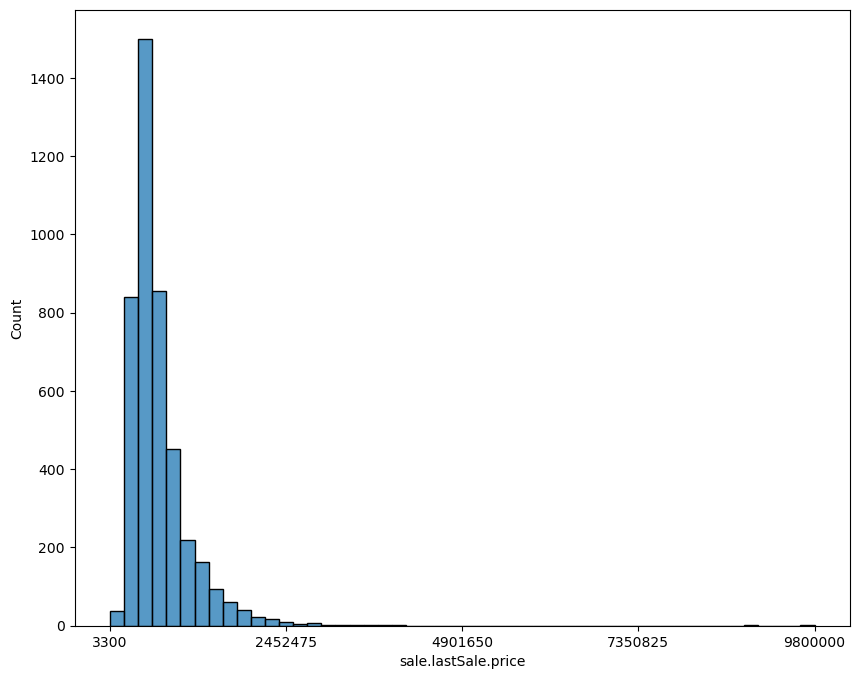

In [20]:
#show distribution of the target variable with seaborn, x axis in dollars, not log scale
import seaborn as sns
#make figsize smaller
plt.figure(figsize = (10, 8))
sns.histplot(main_df[target[0]], bins = 50)
#make xticks to be linspace of min and max in integer values
plt.xticks(np.linspace(main_df[target[0]].min(), main_df[target[0]].max(), 5), labels = np.linspace(main_df[target[0]].min(), main_df[target[0]].max(), 5).astype(int));

##### Create the Dataframe we will work with

In [21]:
features = [address, continuous, ordinal, years, target, one_hot, to_sparse]
features = [x for y in features for x in y]
print( f' df rows: {main_df.shape[0]}, columns: {len(features)}')

 df rows: 4339, columns: 55


In [22]:
df = main_df.loc[:, features]
df

,full_address,address.houseNumber,street,city,state,zip,address.zipPlus4,sold_month,building.totalBuildingAreaSquareFeet,building.bedroomCount,...,assessment.assessmentYear,building.yearBuilt,sale.lastSale.price,building.styleCode,building.roofCover,building.exteriorWalls,building.heatSource,building.constructionType,building.features,homeownerAssociations
0,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913,3913 york blvd,los angeles,ca,90065,3718,may,1121.000000,2.000000,...,2021,1939.000000,1030000.000000,15.000000,Composition Shingle,Stucco,Central,Wood,"['Air Conditioning', 'Fireplace']","[{'type': 'PUD', 'feeAmount': 1200, 'feeFreque..."
1,"3913 York Boulevard, Los Angeles, CA 90065 Sol...",3913,3913 york blvd,los angeles,ca,90065,3718,may,1121.000000,2.000000,...,2021,1939.000000,725000.000000,15.000000,Composition Shingle,Stucco,Central,Wood,"['Air Conditioning', 'Fireplace']","[{'type': 'PUD', 'feeAmount': 1200, 'feeFreque..."
2,"4171 Division Street, Los Angeles, CA 90065 So...",4171,4171 division st,los angeles,ca,90065,4205,december,1250.000000,2.000000,...,2021,1947.000000,905000.000000,15.000000,Composition Shingle,Stucco,Floor/Wall,Wood,[],[]
3,"4171 Division Street, Los Angeles, CA 90065 So...",4171,4171 division st,los angeles,ca,90065,4205,july,1250.000000,2.000000,...,2021,1947.000000,680000.000000,15.000000,Composition Shingle,Stucco,Floor/Wall,Wood,[],[]
4,"4234 Palmero Drive, Los Angeles, CA 90065 Sold...",4234,4234 palmero dr,los angeles,ca,90065,4251,september,1258.000000,2.000000,...,2021,1955.000000,1260000.000000,15.000000,Composition Shingle,Stucco,Central,Wood,['Fireplace'],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,"2013 N Corlett Avenue, Los Angeles, CA 90059 S...",2013,2013 n corlett ave,los angeles,ca,90059,3626,december,1796.000000,4.000000,...,2021,1945.000000,200000.000000,NaN,NaN,NaN,Floor/Wall,Wood,[],"[{'type': 'HOA', 'feeAmount': 400, 'feeFrequen..."
4335,"2307 E 120th St, Los Angeles, CA 90059 Sold Au...",2307,2307 e 120th st,los angeles,ca,90059,2629,august,753.000000,2.000000,...,2021,1915.000000,560000.000000,NaN,NaN,NaN,NaN,Wood,[],"[{'type': 'HOA', 'feeAmount': 300, 'feeFrequen..."
4336,"2307 E 120th Street, Los Angeles, CA 90059 Sol...",2307,2307 e 120th st,los angeles,ca,90059,2629,november,753.000000,2.000000,...,2021,1915.000000,335000.000000,NaN,NaN,NaN,NaN,Wood,[],"[{'type': 'HOA', 'feeAmount': 300, 'feeFrequen..."
4337,"11709 Compton Avenue, Los Angeles, CA 90059 So...",11709,11709 compton ave,los angeles,ca,90059,1826,march,744.000000,4.000000,...,2021,1927.000000,255000.000000,15.000000,Composition Shingle,Stucco,Floor/Wall,Wood,[],"[{'type': 'HOA', 'feeAmount': 700, 'feeFrequen..."


### c) Simple Imputation and Feature Cleaning

#### Drop rows where target value is missing

In [23]:
df.dropna(subset = [target[0], target_year[0]], inplace= True) #drop all rows without a target value
df.replace('nan', np.nan, inplace = True) #replace all 'nan' strings with np.nan
df.shape[0]

4334

#### Fix "Year" Features (make them all integer format, and not datetime)

In [24]:
def take_year(x):
    try:
        x = x.split('-')
        x = int(x[0])
    except:
        x = int(float(x))
    return x

current_year = int(date.today().year)
for year in years:
    print(year)
    
    #if year is an integer, fillna with mode. If year is a float, convert to int while handling the nan values.
    if df[year].dtype == 'int64':
        print('int64')
        df[year].fillna(df[year].mode()[0], inplace = True)
    elif df[year].dtype == 'float64':
        print('float64')
        df[year].fillna(df[year].mode()[0], inplace = True)
        df[year] = df.loc[:, year].astype(int)
        # df[df[year] > current_year] = current_year
    elif df[year].dtype == 'object':
        try:
            print('object')
            df[year].fillna(df[year].mode()[0], inplace=True)
            df[year] = df.loc[:, year].astype(int)

        except:
            print('else')
            df[year].fillna(df[year].mode()[0], inplace=True) #If not numerical, than apply the take_year function
            df[year] = df[year].apply(take_year)
            df.loc[:, year] = df.loc[:, year].astype(int)
    
    #drop row if length of the year string is not 4
    for x in df[year]:
        if len(str(x))<4 or len(str(x))>4:
            df.drop(df[df[year] == x].index, inplace = True)
        # df[df[year] > current_year] = current_year


sale.lastSale.saleDate
object
else
sale.priorSale.saleDate
object
else
assessment.assessmentYear
int64
building.yearBuilt
float64


#### Adjust Prices for Inflation

In [25]:
#Apply current price adjusted for inflation
from datetime import datetime
import cpi
def apply_cpi(x, price_col, year_col):
    if pd.isnull(x.loc[price_col]) == False or x.loc != None:
        price = x.loc[price_col]
        year = x.loc[year_col]
        month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
        month = x.loc['sold_month'][:3].lower()
        if month not in month_names:
            month = 'jan'
        if year == 2022 and month =='dec':
            month = 'nov'
        #convert month to its numerical value
        date_string = f"{year} {month}"
        date = datetime.strptime(date_string, "%Y %b")

        # if year != current_year:
            # print(price, year)
            #combine year and month to datetime format to get the correct CPI value
        # year = str(year) + '-' + str(month)
        val = cpi.inflate(price, date, items= 'Housing', )
        x.loc[price_col] = val
        return x
# df = df.apply(apply_cpi, args = ('sale.lastSale.price', 'sale.lastSale.saleDate'), axis = 1)
# df = df.apply(apply_cpi, args = ('assessment.totalAssessedValue', 'assessment.assessmentYear'), axis = 1)
for pair in price_year_pairings:
    print(pair)
    df = df.apply(apply_cpi, args = (pair), axis =1)

('sale.priorSale.price', 'sale.priorSale.saleDate')
('sale.lastSale.price', 'sale.lastSale.saleDate')
('assessment.assessedImprovementValue', 'assessment.assessmentYear')
('assessment.assessedLandValue', 'assessment.assessmentYear')


#### Sparse House and HOA Features

There are two columns with valuable features, but their columns contain dictionaries with multiple features:

In [26]:
to_sparse

['building.features', 'homeownerAssociations']

To fix this, we just need to do a quick sparsing of the features:

In [27]:
houses_features = []
a = df.loc[:,['building.features']].values
for x in a:
    features_dict = {'AC': 0, 'Fireplace': 0, 'SolarHeat': 0, 'EvaporativeCooler': 0, 'AttachedGarage': 0, 'SpaorHotTub': 0, 'Spa': 0, 'Pool': 0, 'Garage': 0}
    for y in x:
        attr = y.replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
        for item in attr:
            if "Conditioning" in item:
                if "Wall" in item:
                    features_dict['AC'] = 1
                elif "Central" in item:
                    features_dict['AC'] = 3
                else:
                    features_dict['AC'] = 2
            else:
                features_dict[item] = 1
    houses_features.append(features_dict)
features_df = pd.DataFrame(houses_features)
df = df.join(features_df).drop(['building.features'], axis = 1)

##### Now the HOA column

In [28]:
#grab the "type" and "amount" from the homeownerAssociations column. The column contains a dictionary with those two values

def get_hoa_type(x):
    if pd.isnull(x) == False:
        x = x.replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
        for item in x:
            if 'type' in item:
                hoa = item.split(":")[1].replace("'", "").replace("}", "")
                return hoa
    else:
        return np.nan

def get_hoa_amount(x):
    if pd.isnull(x) == False:
        x = x.replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")
        for item in x:
            if 'feeAmount' in item:
                amount = int(item.split(":")[1].replace("'", "").replace("}", ""))
                return amount

    else:
        return np.nan

df['hoa_type'] = df.homeownerAssociations.apply(get_hoa_type)
df['hoa_amount'] = df.homeownerAssociations.apply(get_hoa_amount)
df.drop('homeownerAssociations', axis = 1, inplace = True)

#### d) Row Wise Fill of null values

##### Normally it is ideal to wait until train and tests splits to fill in null values, as to not cause a data leak of the test set into the train set. That is why we now are only going to fill in features whose Null values can be filled by other features in their own row.

In [29]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing = missing/df.shape[0]
missing

building.fullBathroomCount             0.000462
building.bathroomCount                 0.000462
living_area_tagged                     0.000693
building.totalBuildingAreaSquareFeet   0.000924
building.bedroomCount                  0.000924
lot.lotSizeSquareFeet                  0.001386
EvaporativeCooler                      0.002310
SolarHeat                              0.002310
Fireplace                              0.002310
AC                                     0.002310
Spa                                    0.002310
AttachedGarage                         0.002310
Pool                                   0.002310
Garage                                 0.002310
SpaorHotTub                            0.002310
building.constructionType              0.002772
sale.priorSale.price                   0.005313
building.buildingQualityCode           0.012705
mls.bathroomCount                      0.016632
mls.bedroomCount                       0.016632
building.heatSource                    0

In [30]:
df.loc[:, 'mls.floorCount'].fillna(df.loc[:, 'building.storyCount'], inplace = True)
df.drop(['building.storyCount'], axis = 1, inplace = True)

df.loc[:, 'mls.bathroomCount'].fillna(df.loc[:, 'building.bathroomCount'], inplace = True)
df.drop(['building.bathroomCount'], axis = 1, inplace = True)

df.loc[:, 'mls.bedroomCount'].fillna(df.loc[:, 'building.bedroomCount'], inplace = True)
df.drop(['building.bedroomCount'], axis = 1, inplace = True)

df.loc[:, 'mls.lotSizeSquareFeet'].fillna(df.loc[:, 'lot.lotSizeSquareFeet'], inplace = True)
df.drop(['lot.lotSizeSquareFeet'], axis = 1, inplace = True)

df.loc[:, 'living_area_tagged'].fillna(df.loc[:, 'building.totalBuildingAreaSquareFeet'], inplace = True)
df.drop(['building.totalBuildingAreaSquareFeet'], axis = 1, inplace = True)
df.drop('', axis = 1, inplace = True)

In [31]:
# fill in missing values with the mode of the building exterior walls
df.loc[:, 'building.exteriorWalls'].fillna(df.loc[:, 'building.exteriorWalls'].mode()[0], inplace = True)

In [32]:
#Fill Kitchen_level_tagged with average value
df.loc[:, 'Kitchen_level_tagged'].fillna(df.loc[:, ['Bathroom_mean_tagged', 'Floor_mean_tagged', 'Walls_mean_tagged']].mean(axis = 1), inplace = True)
df.loc[:, 'Kitchen_level_std_tagged'].fillna(df.loc[:, ['Bathroom_std_tagged', 'Floor_std_tagged', 'Walls_std_tagged']].mean(axis = 1), inplace = True)

In [33]:
##### We are also going to drop a few columns, as almost all of the values are 0 or null
#drop porc soloarheat and underground/basement garage, only if they exist as columns
for col in ['Porch', 'SolarHeatedPool', 'Underground/BasementGarage', 'DetachedGarage']:
    cols = df.columns
    if col in cols:
        df.drop(col, axis = 1, inplace = True)

For the hoa type and the hoa amount, we can assume they are null intentionally-- they don't belong to an hoa.

In [34]:
#fill hoa_amount with 0, and hoa type with 'None'
df.loc[:, 'hoa_amount'].fillna(0, inplace = True)
df.loc[:, 'hoa_type'].fillna('None', inplace = True)

#### For the rest of the features, there isn't any specific explanation as to why they are missing. Therefore later, we will use more advanced imputation methods to fill them, once we split the dataset into train and test.

#### Check for Skew

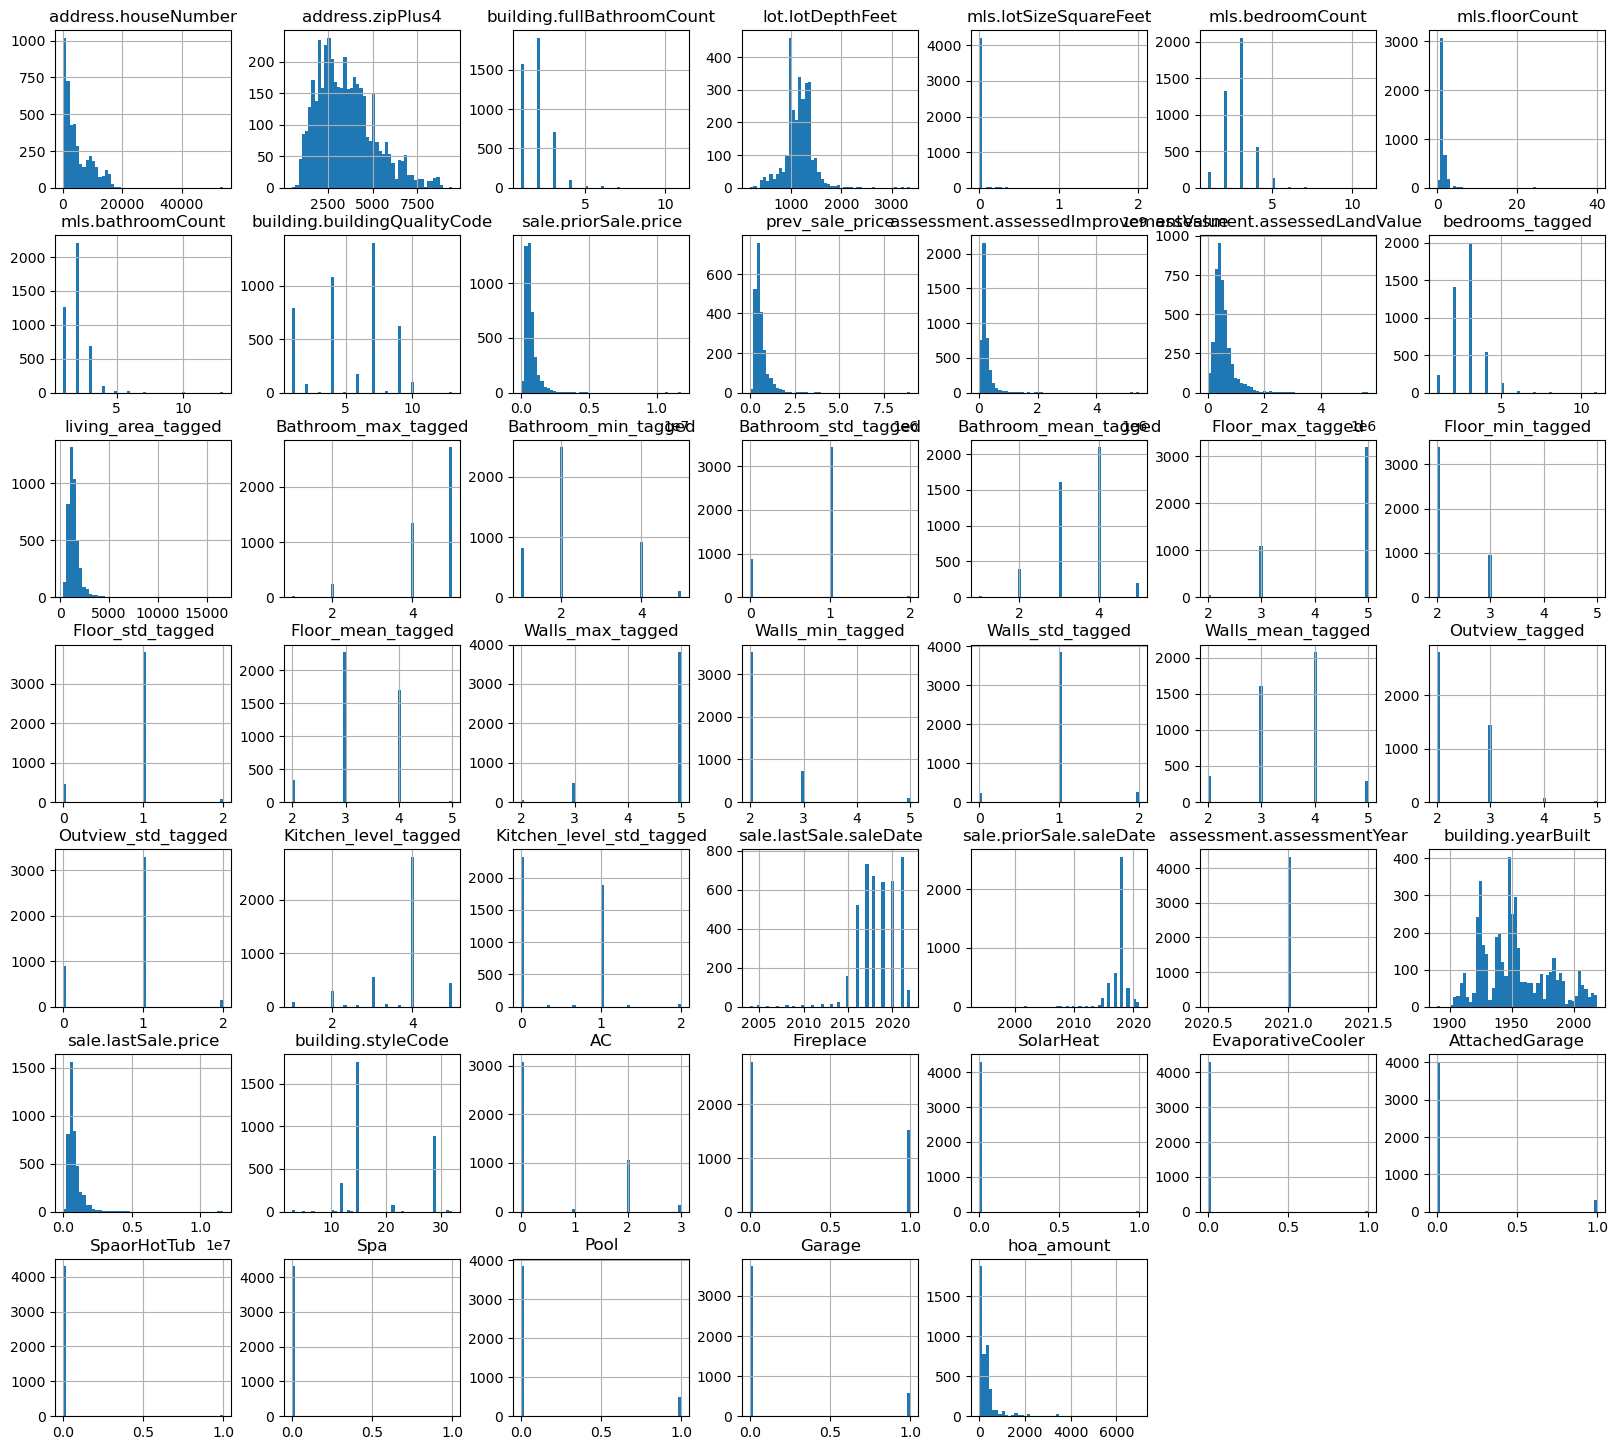

In [35]:
#Perform basic EDA on the dataset
df.hist(bins=50, figsize=(20,18))
plt.show()


A couple of the features here look skewed at first sight. But further understanding of the features shows that the apparent skew is more likely to do errant values. For example, the mls.floorCount feature is normal in the beginning, but then widens out to values which are unrealistic for floor counts.

Similarly with the hoa_amount. The large values might be due to the fact that the large amounts are yearly aggregates, as opposed to monthly aggregates like the rest of the rows.

These features should be handled with outlier removal. 

**The skews which do seem to exist are in the pricing features, such as the target and the prior sale. It very well could be that fixing their skew could help.**

#### Coorelations to the Target Variable

In [36]:
#more eda
import seaborn as sns

#show coorelations to the sale.lastSale.price variable where the correlation is greater than 0.5
corr_matrix = df.corr()
corr_matrix["sale.lastSale.price"].sort_values(ascending=False)
#now show only the coorelations that are greater than 0.5
corr_matrix["sale.lastSale.price"][corr_matrix["sale.lastSale.price"].abs() > 0.4].sort_values(ascending=False)



/tmp/ipykernel_224872/1515602106.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


sale.lastSale.price                   1.000000
sale.priorSale.price                  0.954254
prev_sale_price                       0.951158
assessment.assessedLandValue          0.865435
assessment.assessedImprovementValue   0.784713
living_area_tagged                    0.708997
building.fullBathroomCount            0.543087
mls.bathroomCount                     0.542939
bedrooms_tagged                       0.444702
mls.bedroomCount                      0.429212
Name: sale.lastSale.price, dtype: float64

The living area, bathroom count, and bedroom count seem to have the largest coorelations with the target variable.

## 2)Feature Engineering

Aggregation filling

#### Create Age Column

In [37]:
df['age'] = df['sale.lastSale.saleDate'] - df['building.yearBuilt']

#### Create Overall Quality and average quality columns

In [38]:
df['overall_quality'] = df[['Kitchen_level_tagged', 'Bathroom_mean_tagged', 'Floor_mean_tagged', 'Walls_mean_tagged', 'Outview_tagged']].mean(axis=1)
df['average_std_tagged'] = df[['Bathroom_std_tagged', 'Floor_std_tagged', 'Walls_std_tagged', 'Outview_std_tagged', 'Kitchen_level_std_tagged']].mean(axis=1)
df['average_max_tagged'] = df[['Bathroom_max_tagged', 'Floor_max_tagged', 'Walls_max_tagged']].mean(axis=1)
df['average_min_tagged'] = df[['Bathroom_min_tagged', 'Floor_min_tagged', 'Walls_min_tagged']].mean(axis=1)

#### One Hot Encoding

In [39]:
df = pd.get_dummies(df, columns= one_hot)

#### Ordinal Encoding

In [40]:
ordinal.append('hoa_type')

In [41]:
from sklearn.preprocessing import OrdinalEncoder
# df.loc[:, ordinal] = ord.fit_transform(df['building.buildingQualityCode'].values.reshape(len(df['building.buildingQualityCode']), 1))
ord_encoders = {}
for col in ordinal:
    ord = OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value= len(df[col]) +1)
    ord_encoders[col] = ord
    df[col] = ord.fit_transform(df[col].values.reshape(len(df[col]), 1))

# for col in ordinal:
#     df[col] = ord_encoders[col].transform(df[col])

#### Outlier Removal: Remove all rows where chosen feature has a zscore of less than X amount

In [42]:
df.shape

(4329, 95)

In [43]:
#create a grid search for an SVR model


In [44]:
from scipy import stats
statcols = ['sale.lastSale.price']
# df['statcol'] = df[target] - df[target]
statcols = ['sale.lastSale.price', 'living_area_tagged']
abs_z_scores = np.abs(stats.zscore(df[statcols]))
filtered_entries = (abs_z_scores < 3.5).all(axis=1)
train = df[filtered_entries]
# train.drop(['statcol'], axis = 1, inplace = True)
#drop target lower than 100000
train = train[train['sale.lastSale.price'] > 100000]

#if hoa is above 2000, divide by 12
train.loc[train['hoa_amount'] > 2000, 'hoa_amount'] = train.loc[train['hoa_amount'] > 2000, 'hoa_amount']/12

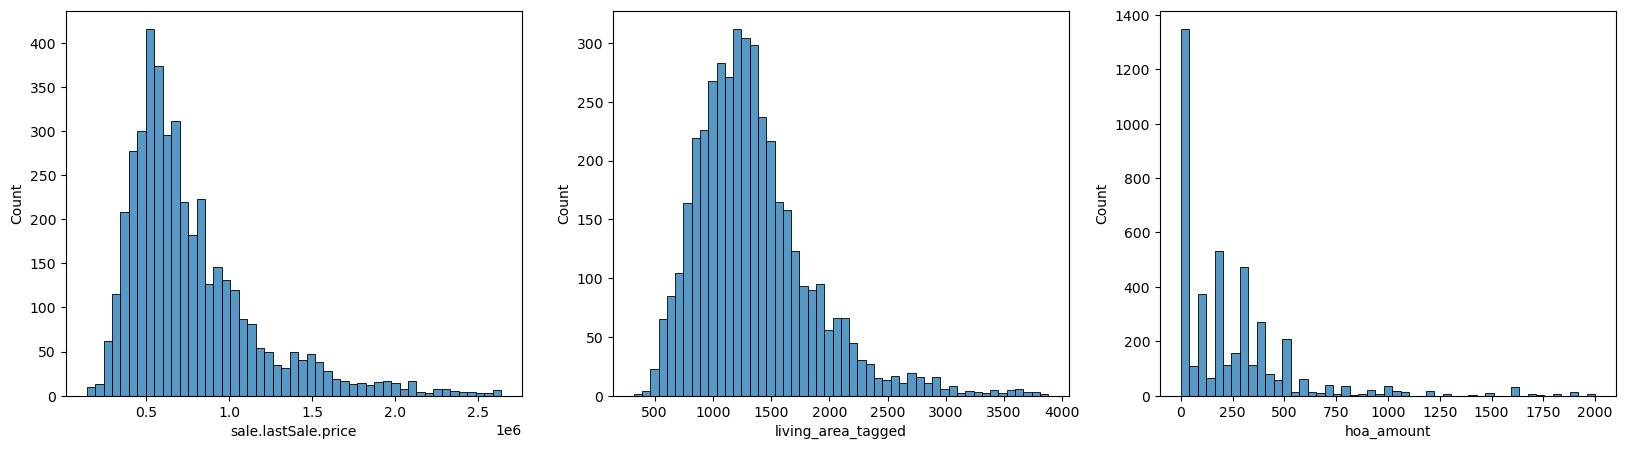

In [45]:
#Show the distributions after we removed teh outliers
statcols.append('hoa_amount')
fig, ax = plt.subplots(1, len(statcols), figsize = (20, 5))
for i, col in enumerate(statcols):
    sns.histplot(train[col], ax = ax[i])
plt.show()

#### Fix the Skewed Features

In [46]:
train['assessment.assessedImprovementValue'] = np.log1p(train['assessment.assessedImprovementValue'])
train['assessment.assessedLandValue'] = np.log1p(train['assessment.assessedLandValue'])
train['sale.priorSale.price'] = np.log1p(train['sale.priorSale.price'])

## 3)Final Data Preperations

#### Fix the Skews, Min-Max Scaling, KNN imputation, Drop Unrelated Columns, Train Test Splits

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer


def process_data(train_df, with_prev_sales):
    if with_prev_sales==False:
        train_df = train_df.dropna(subset = ['prev_sale_price'])
    #drop columns that are address related
    train_df = train_df.loc[:, ~train_df.columns.str.contains('^address')]
    train_df = train_df.drop(['full_address','street', 'city', 'state', 'zip'], axis = 1)
    
    #drop years (if calculated the age)
    train_df = train_df.drop(years, axis =1)
    if with_prev_sales==False:
        train_df = train_df.drop(['prev_sale_price', 'sold_month'], axis = 1) #drop prev_sale_price, as we use the sale.priorSale.price
    #split target
    target = train_df.loc[:, 'sale.lastSale.price']
    train_df = train_df.drop(['sale.lastSale.price'], axis = 1)

    #Train test splits
    #if with_prev_sales==True, stratify on if the prev_sale_price is null or not
    if with_prev_sales==True:
        x_train, x_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=42, stratify = train_df['prev_sale_price'].isnull())
        x_train = x_train.drop(['prev_sale_price', 'sold_month'], axis = 1)
        x_test = x_test.drop(['prev_sale_price', 'sold_month'], axis = 1)
    else:
        x_train, x_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=42)
    columns = x_train.columns
    #MinMaxScaling
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    #KNN Imputation
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(x_train)
    x_train = pd.DataFrame(imputer.transform(x_train), columns=columns)
    x_test = pd.DataFrame(imputer.transform(x_test), columns=columns)

    return x_train, x_test, y_train, y_test

## 4)Modeling

In [143]:
import xgboost
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
### MEan absolute percentage error: np.mean(np.abs((y_true - y_pred) / y_true))

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore', module='sklearn')

def get_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return pd.Series({'Mean Abs. Error': mae, 'Root Mean Squared Error': rmse, 'Mean Percentage Error': mape})

def model_training(x_train, x_test, y_train, y_test):

    #Set the parameters for the grid search
    ridge_alphas = [0.005, 0.05, 0.1, 1, 3, 5]
    lasso_alphas = np.array([1e-5, 5e-5, 0.0001, 0.0005])
    elastic_l1_ratios = np.linspace(0.1, 0.9, 5)
    #parameters for random forest
    svr_param_grid={"kernel" : ["poly"], 'degree':[3,4], "C": [1e1, 1e2], "gamma": np.logspace(-2, 2, 3)},
    dt_grid = {'max_depth': [3, 5, 10],
                'min_samples_split': [2, 5, 10]}
    rf_param_grid = {'n_estimators': [100, 300, 500],
                    'max_depth': [3, 5, 10, 20],
                    'min_samples_split': [2, 5, 10]}


    #Instantiate the Grid Searches
    ridgeCV = RidgeCV(alphas=ridge_alphas,store_cv_values=True)
    lassoCV = LassoCV(alphas=lasso_alphas, cv=3)
    elasticNetCV = ElasticNetCV(alphas=lasso_alphas, l1_ratio=elastic_l1_ratios, cv=3)
    svr  = GridSearchCV(SVR(), svr_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    dt = GridSearchCV(DecisionTreeRegressor(), dt_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rf = GridSearchCV(RandomForestRegressor(), rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

    #Fit the Grid Searches
    ridgeCV.fit(x_train, y_train)
    lassoCV.fit(x_train, y_train)
    elasticNetCV.fit(x_train, y_train)
    svr.fit(x_train, y_train)
    dt.fit(x_train, y_train)
    rf.fit(x_train, y_train)

    #Get the predictions
    y_ridgecv=ridgeCV.predict(x_test)
    y_lasso=lassoCV.predict(x_test)
    y_elastic=elasticNetCV.predict(x_test)
    y_svr = svr.predict(x_test)
    y_dt = dt.predict(x_test)
    y_rf = rf.predict(x_test)
    
    #Get the metrics
    ridgeCV_results = get_metrics(y_test, y_ridgecv)
    lassoCV_results = get_metrics(y_test, y_lasso)
    elasticNetCV_results = get_metrics(y_test, y_elastic)
    svr_results = get_metrics(y_test, y_svr)
    dt_results = get_metrics(y_test, y_dt)
    rf_results = get_metrics(y_test, y_rf)
    labels = ['Ridge', 'Lasso', 'ElasticNet','SVR', 'Decision Tree', 'Random Forest']

    #Make a dataframe of the results
    rmse_df = pd.DataFrame([ridgeCV_results, lassoCV_results, elasticNetCV_results, svr_results, dt_results, rf_results], index=labels)
    return rmse_df

def get_xgboost(x_train, x_test, y_train, y_test):
    params = {
        'colsample_bytree': [1.0],
        'max_depth': [4, 5, 6,7,8],
        'learning_rate': [0.05, 0.1, 0.3],
        'n_estimators': [200, 250,300,350,400, 500, 700],
        'min_child_weight': [1, 2, 3, 5],
        'gamma': [0.0, 0.1, 0.3],
        }
    xgboost_model = GridSearchCV(xgboost.XGBRegressor(), params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    xgboost_model.fit(x_train, y_train)
    y_pred = xgboost_model.predict(x_test)
    #make dataframe from the results Series
    results = pd.DataFrame(get_metrics(y_test, y_pred), columns=['Results']).transpose()
    return results, xgboost_model.best_estimator_, xgboost_model.best_params_

### Modeling **With Out** Previous Sales

##### Our machine learning models are not able to learn with Null values. Therefore we need to drop the rows iwth null values in the prev_sale_price column

In [147]:
x_train, x_test, y_train, y_test = process_data(train, with_prev_sales=False)

rmse_df = model_training(x_train, x_test, y_train, y_test)

In [148]:
rmse_df

,Mean Abs. Error,Root Mean Squared Error,Mean Percentage Error
Ridge,124929.783011,176247.930646,0.162599
Lasso,124164.410697,173440.347595,0.163607
ElasticNet,124690.800768,175510.482163,0.162715
SVR,105710.364935,151861.516876,0.130118
Decision Tree,99394.847459,149032.558552,0.123983
Random Forest,73014.898450,123130.098628,0.090013


In [149]:
xgboost_results, xgb, best_params= get_xgboost(x_train, x_test, y_train, y_test)
print('XGBOOST results:')
print(best_params)
xgboost_results

XGBOOST results:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 250}


,Mean Abs. Error,Root Mean Squared Error,Mean Percentage Error
Results,73978.540225,120068.925218,0.091806


### Modeling **With** Previous Sales - XGBoost

##### As we mentioned, XGBoost is able to handle the null values of the previous sales, unlike the other Alogorithms. Lets try that now:

In [150]:
x_train, x_test, y_train, y_test = process_data(train, with_prev_sales=True)

xgboost_results, xgb, best_params= get_xgboost(x_train, x_test, y_train, y_test)

print('XGBOOST results')
print(best_params)
xgboost_results

XGBOOST results
{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200}


,Mean Abs. Error,Root Mean Squared Error,Mean Percentage Error
Results,85325.290122,130374.242550,0.115078


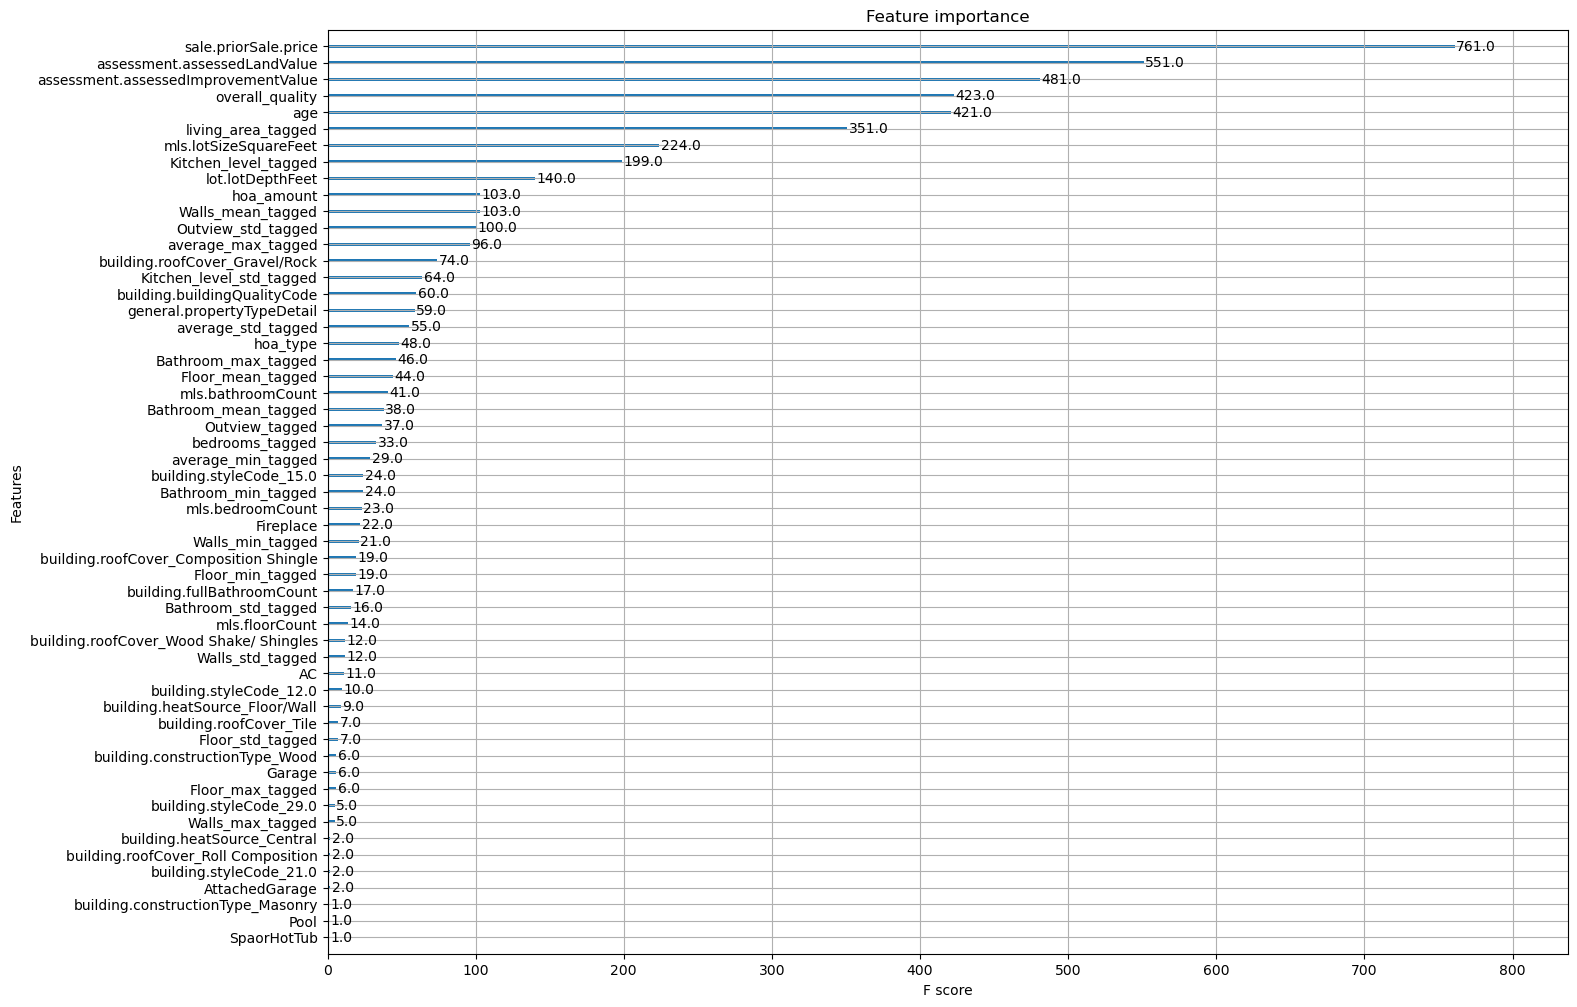

In [151]:
#plot feature importance
xgboost.plot_importance(xgb)
plt.rcParams['figure.figsize'] = [16, 12]
plt.show()


## 5)Utilitizing the Historical Data Qualities 

Up until this point, we haven't really utilized the historical quality of our data. Each row has been its own seperate piece of information. Now, we will try to bring the information of a house's previous sale into its current sale, and see if the model can learn better from the historical data.

In [152]:
train.reset_index(inplace=True, drop=True)

In [153]:
df_dropped_na = train.dropna(subset = ['full_address', 'address.houseNumber', 'street', 'city',
        'state', 'zip', 'Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged',
 'Kitchen_level_tagged',
 'Kitchen_level_std_tagged'], axis = 0)

In [154]:
dub_addresses = df_dropped_na[df_dropped_na[['street']].duplicated(['street'])]['street']
dub_df = df_dropped_na.loc[df_dropped_na['street'].isin(dub_addresses)]
dub_df.shape

(4245, 95)

Group By's (condition differences, price differences) To validate that there is deviation

In [155]:
dub_df.groupby(['street'])[['Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged']].std().head(5)

,Bathroom_max_tagged,Bathroom_min_tagged,Bathroom_std_tagged,Bathroom_mean_tagged,Floor_max_tagged,Floor_min_tagged,Floor_std_tagged,Floor_mean_tagged,Walls_max_tagged,Walls_min_tagged,Walls_std_tagged,Walls_mean_tagged,Outview_tagged,Outview_std_tagged
street,,,,,,,,,,,,,,
1001 w 132nd st,1.414214,0.000000,0.707107,0.707107,1.414214,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10012 s gramercy pl,2.121320,0.000000,0.707107,1.414214,0.000000,0.707107,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10013 westwanda dr,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.707107,0.707107,0.000000
10032 pangborn ave,2.121320,0.707107,0.707107,1.414214,0.000000,0.000000,0.000000,0.000000,1.414214,0.000000,0.000000,0.707107,0.000000,0.707107
10037 beach st,0.707107,1.414214,0.707107,0.000000,0.000000,0.707107,0.707107,0.000000,1.414214,0.707107,0.707107,0.000000,0.000000,0.000000


In [156]:
columns = ['full_address', 'address', 'sale_between', 'Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged',
 'Kitchen_level_tagged',
 'Kitchen_level_std_tagged','overall_quality',
 'average_std_tagged', 'average_max_tagged',
       'average_min_tagged']

aggregation_columns = ['Bathroom_max_tagged',
 'Bathroom_min_tagged',
 'Bathroom_std_tagged',
 'Bathroom_mean_tagged',
 'Floor_max_tagged',
 'Floor_min_tagged',
 'Floor_std_tagged',
 'Floor_mean_tagged',
 'Walls_max_tagged',
 'Walls_min_tagged',
 'Walls_std_tagged',
 'Walls_mean_tagged',
 'Outview_tagged',
 'Outview_std_tagged',
 'Kitchen_level_tagged',
 'Kitchen_level_std_tagged',
 'overall_quality',
 'average_std_tagged', 'average_max_tagged',
       'average_min_tagged']
 
difference_df = pd.DataFrame(columns = columns)
dub_df = dub_df.sort_values(by = ['street', 'sale.lastSale.saleDate']).reset_index(drop=True)

#### Group the Dataframe by its address and its sales, and gather the historical data

In [157]:
list_of_data = []
for house in dub_df['street'].unique():
    house_df = dub_df[dub_df['street'] == house].sort_values(by = ['sale.lastSale.saleDate'], ascending = False)
    sale_b_idx = 0
    for i, sale_a in house_df.iterrows():
        sale_b_idx +=1 
        if sale_b_idx < len(house_df):
            sale_b = house_df.iloc[sale_b_idx]
            data_point = dict()
            data_point['full_address'] = sale_a['full_address']
            data_point['time_between_sales'] = int(sale_a['sale.lastSale.saleDate']) - int(sale_b['sale.lastSale.saleDate'])
            for col in aggregation_columns: #Calculate the differences between the quality columns.
                data_point[f'difference_{col}'] = int(sale_a[col]) - int(sale_b[col])
            list_of_data.append(data_point)
        else:

            data_point = dict()
            data_point['full_address'] = sale_a['full_address']
            data_point['time_between_sales'] = int(sale_a['sale.lastSale.saleDate']) - int(sale_b['sale.lastSale.saleDate'])
            for col in aggregation_columns:
                data_point[f'difference_{col}'] = np.nan
            list_of_data.append(data_point)

difference_df = pd.DataFrame.from_records(list_of_data)

In [158]:
#feature names must be unique
diff_df = dub_df.merge(difference_df, left_index=True, right_index=True, suffixes=('', '_diff')) 
#drop columns ending in _diff
diff_df = diff_df.loc[:,~diff_df.columns.str.endswith('_diff')]

#### Trying the model again, dropping the rows with the previous sale prices

In [159]:
x_train, x_test, y_train, y_test = process_data(diff_df, with_prev_sales=False)

rmse_df = model_training(x_train, x_test, y_train, y_test)
rmse_df

,Mean Abs. Error,Root Mean Squared Error,Mean Percentage Error
Ridge,136750.540243,187861.756805,0.173692
Lasso,136532.048342,187810.604420,0.175098
ElasticNet,136485.915416,187354.686188,0.173579
SVR,103816.703928,157445.666781,0.123863
Decision Tree,98072.910448,146312.760192,0.114446
Random Forest,74696.437590,121558.637142,0.088533


In [160]:
xgboost_results, xgb, best_params= get_xgboost(x_train, x_test, y_train, y_test)
print('XGBOOST results')
print(best_params)
xgboost_results

XGBOOST results
{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300}


,Mean Abs. Error,Root Mean Squared Error,Mean Percentage Error
Results,74469.467169,117750.796272,0.089328


### Trying again **With** the previous sales

In [161]:
x_train, x_test, y_train, y_test = process_data(diff_df, with_prev_sales=True)
xgboost_results, xgb, best_params= get_xgboost(x_train, x_test, y_train, y_test)

In [162]:
print('XGBOOST results')
print(best_params)
xgboost_results

XGBOOST results
{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 350}


,Mean Abs. Error,Root Mean Squared Error,Mean Percentage Error
Results,69669.174828,108002.258385,0.100218


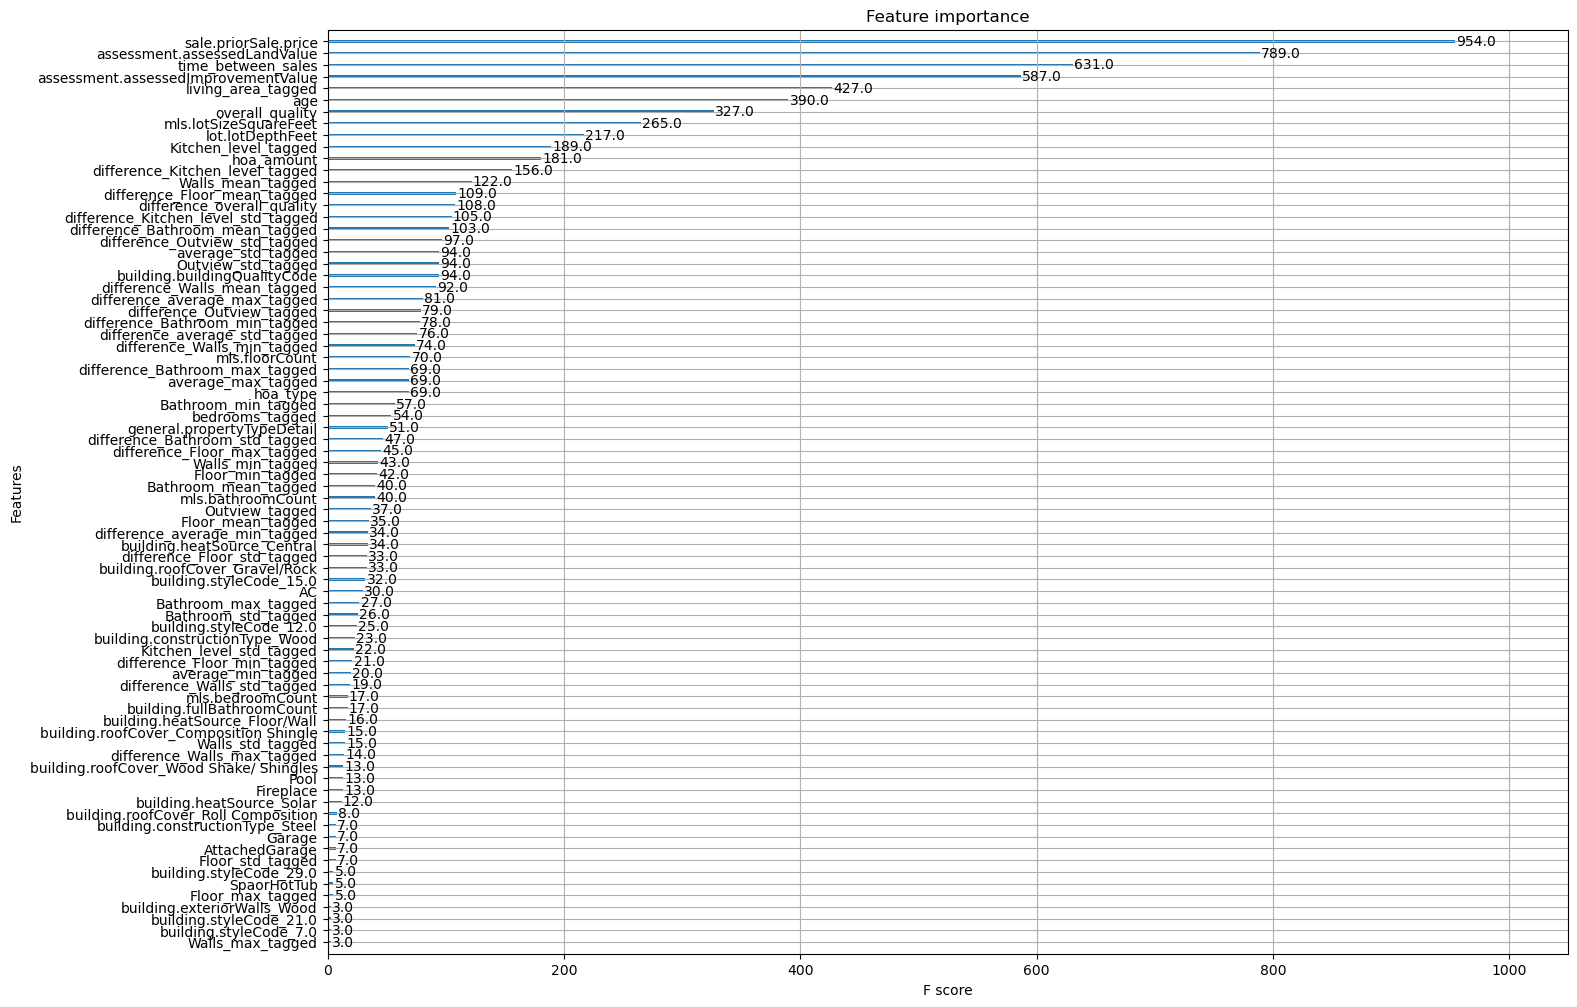

In [163]:
#plot feature importance
xgboost.plot_importance(xgb)
plt.rcParams['figure.figsize'] = [16, 16]
plt.show()


## 6) In Conclusion

XGBoost with the previous sale rows, as well as the aggregations from the previous sale to the current sale exceeds the other models exceedingly.

**Business Takeaways**:

Our best models fall with in the 10% range of error. This is promising. However, Zillow and other companies have claimed in recent years to have reached thee 5% marker with their models, therefore further work is still needed. What else is there left to do?

1) Gather **More** data

2) Gather **More** cities
    * For example, unable currently to use the zip code-- a very valuable feature.
    
3) Understand better the houses with the larget error.
4) Use nearest neighbors to get the price of the closest neighbors (KNN and ALSO physical Neighbors)
5) PCA or other feature extraction tools (although with Gradient boosting methods, there isn't so much data to show that this will help).
    * https://stats.stackexchange.com/questions/518532/does-it-make-sense-to-do-pca-before-a-tree-boosting-model
